In [38]:
import dit
import numpy as np
import scipy.stats as st
import string
import itertools
import random
from derkjanistic_nudges import max_derkjanistic_nudge as max_dj_nudge
from derkjanistic_nudges import do_derkjanistic_nudge as dj_nudge
import distribution_sampler as sampler
from tqdm.notebook import tqdm
from typing import List, Dict
from dit.validate import InvalidNormalization
from dit.exceptions import ditException

import matplotlib.pyplot as plt

import multiprocessing as mp
import os
import time


#from optimized_nudges import max_nudge

# Utils

In [2]:

def get_vars(n_vars: int) -> List[str]:
    vs = ['X{}'.format(i) for i in range(n_vars-1)]
    vs.append('Y')
    return vs

def get_labels(n_vars: int, n_states: int) -> List[str]:
    if n_states < 1 or n_states > 10:
        raise ValueError("states should be greater than 0 and  less than or equal to 10")
    return [''.join(i) for i in itertools.product(string.digits[:n_states], repeat=n_vars)]


def generate_distribution(n_vars: int, n_states: int, entropy_level: float, base=np.e) -> dit.Distribution:
    var_names = get_vars(n_vars)
    state_labels = get_labels(n_vars, n_states)
    pmf = sampler.sample(n_states**n_vars, level=entropy_level)
    if base == np.e:
        pmf = np.log(pmf)
    d = dit.Distribution(state_labels, pmf=pmf, base=base)
    d.set_rv_names(var_names)
    return d

def get_marginals(d: dit.Distribution) -> (dit.Distribution, List[dit.Distribution]):
    rvs = d.get_rv_names()[:-1]  #everything except the output
    return d.condition_on(rvs)

def get_joint(X: dit.Distribution, YgX: List[dit.Distribution], base=np.e) -> dit.Distribution:
    return dit.joint_from_factors(X, YgX).copy(base=base)

def print_conditional(YgX):
    for i, Y in enumerate(YgX):
        Y.make_dense()
        print("{}: ".format(i), Y.pmf)


In [35]:
def combine_results(results):
    return np.vstack([res[1] for res in results])

def create_dicts(res_array, dists, levels=4, n_vars=6):
    print(res_array.shape)
    res_dict = {0.75 + i*0.05 : np.reshape(res_array[i*n_vars*dists:dists*n_vars*(i+1),:], (n_vars,-1,res_array.shape[-1])) for i in range(levels)}
    means_dict = {l: arr.mean(axis=1) for l,arr in res_dict.items()}
    std_dict = {l: arr.std(axis=1)/np.sqrt(dists) for l, arr in res_dict.items()}
    ci_dict = {l: st.norm.interval(0.95, loc=mean, scale=std) for ((l, mean), (l1, std)) in zip(means_dict.items(), std_dict.items())}
    return means_dict, std_dict, ci_dict

def plot_results(n_vars, levels, dicts, main_title):
    means_dict, std_dict, ci_dict = dicts
    fig, axes = plt.subplots(ncols= 4, nrows=1, figsize=(20,5))
    for i, level in enumerate(levels):
        axes[i].plot(n_vars, means_dict[level][:,0], label='individual')
        axes[i].fill_between(n_vars, ci_dict[level][0][:,0],ci_dict[level][1][:,0], alpha=0.2)

        axes[i].plot(n_vars, means_dict[level][:,1], label='local')
        axes[i].fill_between(n_vars, ci_dict[level][0][:,1],ci_dict[level][1][:,1],  alpha=0.2)

        axes[i].plot(n_vars, means_dict[level][:,2], label='synergistic')
        axes[i].fill_between(n_vars, ci_dict[level][0][:,2],ci_dict[level][1][:,2], alpha=0.2)
        axes[i].plot(n_vars, means_dict[level][:,3], label='derkjanistic')
        axes[i].fill_between(n_vars, ci_dict[level][0][:,3],ci_dict[level][1][:,3], alpha=0.2)



        axes[i].plot(n_vars, means_dict[level][:,4], label='global')
        axes[i].fill_between(n_vars, ci_dict[level][0][:,4],ci_dict[level][1][:,4],alpha=0.2)

        axes[i].set_title("Entropy level: {}, nudge size: 0.01".format(level) )
        axes[i].set_xlabel("Number of variables")
        axes[i].set_ylabel("Impact")
        #axes[i].set_yscale('log')
        axes[i].legend()
    fig.suptitle(main_title)
    plt.show()

In [4]:
def log_add(p, n):
    result = np.zeros(len(p), dtype=p.dtype)
    PgeN = p >= n
   # print("PgeN", PgeN, p, n)
    result[PgeN] = p[PgeN] + np.log1p(np.exp(n[PgeN] - p[PgeN]))
    result[~PgeN] = n[~PgeN] + np.log1p(np.exp(p[~PgeN] - n[~PgeN]))
    return result

def log_subtract(p, n):
    result = np.zeros(len(p), dtype=p.dtype)
    
    PleN = p <= n
   # print("PleN", p, n)
    n_is_inf = n == -np.inf
    other = ~PleN & ~n_is_inf
    
    result[PleN] = -np.inf
    result[n_is_inf] = p[n_is_inf]
    result[other] = p[other] + np.log1p(-np.exp(n[other]-p[other]))
    return result

def log_nudge(prob, nudge, s):
    new_prob = np.zeros(len(prob), dtype=prob.dtype)
    #nudge = np.log(np.abs(nudge))
    pos, neg = s > 0, s < 0
  #  print("before positive", prob[pos], nudge[pos])
    new_prob[pos] = log_add(prob[pos], nudge[pos])
  #  print("after positive", new_prob[pos], prob[pos], nudge[pos])
  #  print("before negative", prob[neg], nudge[neg])
    new_prob[neg] = log_subtract(prob[neg], nudge[neg])
  #  print("after negative", new_prob[neg], prob[neg], nudge[neg])
    new_prob[s==0] = prob[s==0]
    return new_prob



# (Random) nudges

In [5]:
def generate_nudge(size: int, eps: float, p=False):
    nudge = np.zeros(size)
    if size % 2 == 0:
        nudge = 0.5*eps*np.random.permutation(np.concatenate([np.random.dirichlet([1.]*int(0.5*size)),
                                                 -np.random.dirichlet([1.]*int(0.5*size))]))
    else:
        u, v = int(np.floor(size/2)), int(np.ceil(size/2))
        nudge = 0.5*eps*np.random.permutation(np.concatenate([np.random.dirichlet([1.]*u),
                                                 -np.random.dirichlet([1.]*v)]))
    if p:
        print(nudge)
    return nudge


def generate_nudge_binomial(size: int, eps: float,  p=False):
    # This generates a nudge using Rick's proposed method
    nudge = np.zeros(size)
    
    split_point = np.random.binomial(size, p=0.5)
    while split_point == 0 or split_point == size-1:
        split_point = np.random.binomial(size, p=0.5)
    nudge[:split_point] = 0.5*eps*np.random.dirichlet([1.]*split_point)
    nudge[split_point:] = -0.5*eps*np.random.dirichlet([1.]*(size-split_point))
    np.random.shuffle(nudge)
    if p:
        print(nudge)
    return nudge


def generate_log_nudge(size: int, eps: float, binomial=False, p=False):
    if binomial:
        nudge = generate_nudge_binomial(size, eps, p)
    else:
        nudge = generate_nudge(size, eps, p)
    return np.log(np.abs(nudge)), np.sign(nudge)

    



def perform_nudge(X, nudge, list_of_idxs=None):
    X.make_dense()
    if list_of_idxs is None:
        X.pmf += nudge
    else:
        #this for loop is for synergistic nudges
        for idxs in list_of_idxs:
            X.pmf[idxs] += nudge
    X.pmf[X.pmf < 0] = 0
    X.normalize()
    
    
def perform_log_nudge(X, nudge, sign, list_of_idxs=None):
    X.make_dense()
   # print("performing log nudge", X.copy('linear').pmf,X.pmf, nudge, sign)
    if list_of_idxs is None:
        result = log_nudge(X.pmf, nudge, sign) 
       # print("performed log nudge", np.exp(result))
        X.pmf = result
        
    else:
        #Synergistic nudges
        for idxs in list_of_idxs:
            X.pmf[idxs] = log_nudge(X.pmf[idxs], nudge, sign)
    X.pmf[X.pmf == np.nan] = -np.inf #log of negative probabilities becomes nan and log of 0 becomes -inf
    X.normalize()
    
    
def individual_nudge(old_X: dit.Distribution, eps : float = 0.01, rvs_other = None) -> dit.Distribution:
    mask = old_X._mask
    base = old_X.get_base()
    if old_X.outcome_length() == 1:
        return global_nudge(old_X, eps)
    
    
    if rvs_other == None:
        rvs = old_X.get_rv_names()
        rvs_other = np.random.choice(rvs, len(rvs)-1, replace=False)
    
    X_other, Xi_given_Xother = old_X.condition_on(rvs_other)
    nudge_size = len(Xi_given_Xother[0])
    
    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps/len(Xi_given_Xother))
        for Xi in Xi_given_Xother:
            perform_nudge(Xi,nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps)
        for Xi in Xi_given_Xother:
            perform_log_nudge(Xi, nudge, sign)
    new_X = dit.joint_from_factors(X_other, Xi_given_Xother).copy(base)
    new_X._mask = mask
    return new_X


def local_nudge1(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    mask = old_X._mask
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    rvs = list(old_X.get_rv_names())

    random.shuffle(rvs)

    new_Xs = np.zeros((len(rvs), len(old_X)))
    for i in range(len(rvs)):
        rvs_other = rvs[:i] + rvs[i+1:]
        tmp = individual_nudge(old_X, eps, rvs_other=rvs_other)
        tmp.make_dense()
        old_X.make_dense()
        if base == 'linear':
            new_Xs[i,:] = tmp.pmf - old_X.pmf
        else:
            new_Xs[i] = tmp.copy(base='linear').pmf - old_X.copy(base='linear').pmf
        old_X.make_sparse()
    nudge = new_Xs.sum(axis=0)
    nudge = eps*nudge/(abs(nudge).sum())
    
    if base == 'linear':
        perform_nudge(new_X, nudge)
    else:
        perform_log_nudge(new_X, np.log(np.abs(nudge)), np.sign(nudge))

    new_X._mask = mask
    return new_X


def local_nudge2(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    mask = old_X._mask
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    rvs = list(old_X.get_rv_names())

    random.shuffle(rvs)

    new_Xs = np.zeros((len(rvs), len(old_X)))
    for i in range(len(rvs)):
        rvs_other = rvs[:i] + rvs[i+1:]
        new_X = individual_nudge(new_X, eps/len(rvs), rvs_other=rvs_other)
    return new_X


local_nudge = local_nudge1


def derkjanistic_nudge(old_X: dit.Distribution, eps: float=0.01) -> dit.Distribution:
    
    base = old_X.get_base()
    new_X = old_X.copy(base='linear')
    rvs = old_X.get_rv_names()
    if len(rvs) < 2:
        return global_nudge(old_X, eps)
    delta = eps/len(old_X)
    new_pmf = dj_nudge(new_X, delta)
    #print(delta)
    new_X.pmf = new_pmf
    
    new_X.normalize()
    new_X = new_X.copy(base='e')
    return new_X

def synergistic_nudge(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    rvs = old_X.get_rv_names()
    if len(rvs) < 3:
        return global_nudge(old_X, eps)
    
    synergy_vars = np.random.choice(len(rvs), 2, replace=False)
    states = old_X.alphabet[0]
    nudge_size = int(len(old_X)/(len(states)**2))
    outcome_dict = { state : np.zeros(nudge_size, dtype=int) for state in list(itertools.product(states, repeat=2))}
    for i, outcome in enumerate(old_X.outcomes):
        cur_state = outcome[synergy_vars[0]], outcome[synergy_vars[1]]
        outcome_dict[cur_state][np.argmax(outcome_dict[cur_state] ==0)] = i #Choose the first zero entry to fill    
    
    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps/len(outcome_dict))
        perform_nudge(new_X, nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps/len(outcome_dict))
        perform_log_nudge(new_X, nudge, sign, outcome_dict.values())
    new_X.pmf[new_X.pmf == np.nan] = -np.inf
    new_X.normalize()
    
    return new_X


def global_nudge(old_X: dit.Distribution, eps: float = 0.01) -> dit.Distribution:
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    nudge_size = len(old_X)

    if base == 'linear':
        nudge = generate_nudge(nudge_size, eps)
        perform_nudge(new_X, nudge)
    else:
        nudge, sign = generate_log_nudge(nudge_size, eps)
        perform_log_nudge(new_X, nudge, sign)
    return new_X

In [6]:
def experiment(inputs):
    level, n_vars,  dists, interventions, seed = inputs
    np.random.seed(seed)
    n_states = 3

    nudges = [individual_nudge, local_nudge, synergistic_nudge, derkjanistic_nudge, global_nudge]
    #nudges = [individual_nudge, local_nudge, synergistic_nudge, global_nudge]
    means = np.zeros((dists, len(nudges)))
    for i in range(dists):
        XY = generate_distribution(n_vars+1, n_states, level) #+1 for the output variable
        old_Y = XY.marginal('Y').copy('linear')
        old_X, YgivenX = get_marginals(XY)
        [Y.make_dense() for Y in YgivenX]
        oldest_X = old_X.copy()
    
        
        intervention_results = np.zeros((len(nudges),interventions))
        for j in range(interventions):
            for idx, nudge in enumerate(nudges):
                if not np.allclose(old_X.pmf,oldest_X.pmf):
                    raise ValueError("Something went wrong during {}. Original X has changed".format(nudge.__name__))
                new_X = None
                try:
                    new_X = nudge(old_X)
                except IndexError as e:
                    print(level,n_vars,nudge, e)
                    raise e
                try:
                    new_Y = dit.joint_from_factors(new_X, YgivenX).marginal('Y').copy('linear')
                except InvalidNormalization as e:
                    print(nudge)
                    print('new_x = {}'.format(sum(new_X.pmf)), new_X.pmf)
                    raise e
                except ditException as e:
                    print(nudge)
                    old_X.make_dense()
                    new_X.make_dense()
                    print(level, n_vars, seed, i,old_X.pmf, new_X.pmf)
                    print(level, n_vars, seed, i, "oldX has {} outcomes, newX has {} outcomes\nYgivenX has {} cond distributions,old_x has 0 outcomes at{}".format(len(old_X),len(new_X), len(YgivenX), np.flatnonzero(old_X.pmf==0)))
                    old_X.make_sparse()
                    raise e
                new_Y.make_dense()
                intervention_results[ idx,j] = sum(abs(new_Y.pmf - old_Y.pmf))#np.linalg.norm(new_Y.pmf - old_Y.pmf, ord=1)
        means[i, :] = np.median(intervention_results, axis=1)
    print(level,n_vars, "done")
    return (level, n_vars), means

In [ ]:
%%time
n_states = 3
n_vars = range(1,7)
levels = [0.75, 0.8, 0.85, 0.9]
dists = 10
interventions = 20
seeds = np.random.randint(0, 2**32-1, len(n_vars)*len(levels))

with mp.Pool(os.cpu_count()) as pool:
    random_results = pool.map(experiment, [(level, n_var, dists, interventions, seeds[i]) for i, (level, n_var) in enumerate(itertools.product(levels, n_vars))])
            

In [ ]:
random_results

In [ ]:
plot_results(n_vars, levels, create_dicts(combine_results(random_results), dists, len(levels), len(n_vars)), "Randomized nudges.\nDerkjanistic nudges implemented")


# Optimized nudges

In [47]:
#Utility functions

def entropy(dist: np.ndarray):
    return st.entropy(dist, base=2)


def R(x, n, vs, states=3):
    x = x.reshape(-1,states)
    for i in range(n % vs):
        x= x.T.reshape(-1,states)
    return x


def find_max_impact(scores, input, eps):
    nudge_vector = find_minimal_subset(scores, input, eps)
    #print("in find max impact, nudge vector found:", nudge_vector)
    positive_nudge = sum(nudge_vector)
    nudge_vector = -nudge_vector
    nudge_vector[np.argmax(scores)] = positive_nudge
    nudge_impact = np.sum(scores*nudge_vector)

    return nudge_vector, nudge_impact


def find_minimal_subset(scores, input, eps):
    nudge_vector = np.zeros(len(input))
    sorted_indices = np.argsort(scores)
    
    minus_weights = np.cumsum(input[sorted_indices])
    # Find the index in the sorted indices whose weight is at most eps
    i = np.argmax(np.cumsum(minus_weights < eps))

    selected_indices = sorted_indices[:i]
    #print(selected_indices)
    #print("the indices",selected_indices)
    if len(selected_indices) > 0:
        selected_weights = input[selected_indices]
        #print(selected_weights, selected_weights.shape)
        selected_weights[-1] = np.amin([selected_weights[-1], eps - sum(selected_weights[:-1])])
    else:
        selected_indices = sorted_indices[0]
        selected_weights = np.amin([eps, abs(eps - input[selected_indices] )])
    nudge_vector[selected_indices] = selected_weights
    #print(nudge_vector, input, eps)
    return nudge_vector


def max_nudge(input, conditional, eps=0.01, nudge_type='individual', minimal_entropy_idx=None):
    minimal_entropy_idx = None
    if nudge_type == 'individual':
        nudge_vector, _, minimal_entropy_idx = max_individual(input, conditional, eps, minimal_entropy_idx)
    elif nudge_type == 'local':
        nudge_vectors, max_impacts = max_local(input, conditional, eps)
        nudge_vector =nudge_vectors

    elif nudge_type == 'synergistic_old':
        nudge_vector, _ = max_synergistic(input, conditional, eps)  # nudge vector is size input
    elif nudge_type == 'derkjanistic':
        nudge_vector, _ = max_derkjanistic(input, conditional, eps)
    elif nudge_type == 'global':
        nudge_vector = max_global(input, conditional, eps)  # nudge vector is size of input
    else:
        raise ValueError("type should be one of (individual, local, synergistic, global)")
    return nudge_vector, minimal_entropy_idx


def max_individual(input : dit.Distribution, conditional : List[dit.Distribution], eps: float=0.01, minimal_entropy_idx = None):
    rvs = input.get_rv_names()
    conditional = np.stack([d.copy('linear').pmf for d in conditional])
    conditional = conditional/conditional.sum()
    
    if not minimal_entropy_idx == 0 and not minimal_entropy_idx:
        minimal_entropy_idx = np.argmin([entropy(input.marginal([rv], rv_mode='indices').pmf) for rv in range(len(rvs))])

    non_minimal_rvs = rvs[:minimal_entropy_idx] + rvs[minimal_entropy_idx +1:]
    non_minimal_marginal, minimal_conditional = input.condition_on(non_minimal_rvs)
    [d.make_dense() for d in minimal_conditional]
    #minimal_conditional = np.stack([d.pmf for d in minimal_conditional])
    #print("minimal_conditional:",minimal_conditional)
    indiv_shape = (len(minimal_conditional), len(minimal_conditional[0]))
    
    #minimal_conditional = minimal_conditional.flatten()
    nudge_vector = np.zeros(indiv_shape)
    rotated_conditional = R(conditional, minimal_entropy_idx, len(rvs))
    total_max_impact = 0
    #print(len(rvs), (eps / 2)/len(minimal_conditional))
    for i, mc_dist in enumerate(minimal_conditional):
        
        rows= rotated_conditional[i*3:(i+1)*3,:]
        
        max_impact =0 
        for allignment in itertools.product([-1, 1], repeat=rotated_conditional.shape[1]):
            allignment = np.array(allignment)
            if np.all(allignment == 1) or np.all(allignment == -1):
                continue
            scores = np.sum(allignment * rows, axis=1)
            

            # Add rotation of scores so that scores are well aligned.
            # Weigh scores using the non_minimal_marginal
            
            vector, impact = find_max_impact(scores, mc_dist.pmf, (eps / 2)/len(minimal_conditional))
            if impact > max_impact:
                nudge_vector[i,:] = vector
                max_impact = impact
        total_max_impact += max_impact
    return nudge_vector, total_max_impact ,minimal_entropy_idx


def max_local(input: dit.Distribution, conditional: List[dit.Distribution], eps: float = 0.01):
    rvs = input.get_rv_names()
    sorted_rvs = np.argsort([entropy(input.marginal([rv], rv_mode='indices').pmf) for rv in range(len(rvs))])
    nudge_vectors = np.zeros((input.outcome_length(), int(len(input)/3), 3)) #For each random variable we get (hopefully) a different nudge vector of len the input size
    max_impacts = np.zeros(input.outcome_length())
    for rv in sorted_rvs:
        nudge_vectors[rv,:,:], max_impacts[rv], _ =  max_individual(input, conditional, eps/len(sorted_rvs), rv)
    return nudge_vectors, max_impacts


def max_synergistic(input: dit.Distribution, conditional: List[dit.Distribution], eps: float =0.01):
    rvs = input.get_rv_names()
    states = input.alphabet[0]
    partition_size = int(len(input) / (len(states) ** 2))
    max_entropy = (len(states) ** 2)* entropy(np.ones(partition_size))
    best_syn_vars = (0, 1)
    best_outcome_dict = {}
    lowest_entropy = max_entropy
    
    # conditional = np.stack([d.pmf for d in conditional]) # stack the conditional
    # conditional = conditional/conditional.sum() # normalize the conditional to give each
    for synergy_vars in itertools.combinations(range(len(rvs)), r=2):
        # Build the outcome dict
        outcome_dict = { state : np.zeros(partition_size, dtype=int) for state in list(itertools.product(states, repeat=2))}
        for i, outcome in enumerate(input.outcomes):
            cur_state = outcome[synergy_vars[0]], outcome[synergy_vars[1]]
            outcome_dict[cur_state][np.argmax(outcome_dict[cur_state] ==0)] = i #Choose the first zero entry to fill

        current_entropy = sum([entropy(input.pmf[indices]) for state, indices in outcome_dict.items()])

        if current_entropy < lowest_entropy:
            best_syn_vars = synergy_vars
            lowest_entropy = current_entropy
            best_outcome_dict = outcome_dict

    # Use best syn vars to find the nudge vector that makes the largest impact
    nudge_vector = np.zeros(len(input))

    for state, indices in best_outcome_dict.items():
        nudge_vector[indices] = max_global(input.pmf[indices], 
                                           [d for i,d in enumerate(conditional) if i in indices], eps/len(best_outcome_dict), False)

    return nudge_vector, best_syn_vars

def max_derkjanistic(input: dit.Distribution, conditional: List[dit.Distribution], eps: float=0.01) -> dit.Distribution:
    
    evo_params = get_config(len(input.get_rv_names()))
    max_dj_nudge_found = max_dj_nudge(input, conditional, eps, evo_params )
    return max_dj_nudge_found.new_dist


def max_global(input: dit.Distribution, conditional: List[dit.Distribution], eps: float= 0.01, first=True):
    max_impact = 0
    nudge_vector = np.zeros(len(input))
    conditional = np.stack([d.copy('linear').pmf for d in conditional]) # stack the conditional
    conditional = conditional/conditional.sum() # normalize the conditional to give each
    for allignment in itertools.product([-1, 1], repeat=conditional.shape[1]):
        allignment = np.array(allignment)
        if np.all(allignment == 1) or np.all(allignment == -1):
            continue
        alligned_conditional =  allignment*conditional
        #print("a",allignment, allignment.shape)
        #print("c",conditional, conditional.shape)
        #print("ac",alligned_conditional, alligned_conditional.shape)
        scores = np.sum(alligned_conditional, axis=1)
        if first:
            vector, impact = find_max_impact(scores, input.pmf, eps / 2)
        else:
            vector, impact = find_max_impact(scores, input, eps / 2)
        #print("impacts", impact, max_impact)
        if impact > max_impact:
            nudge_vector = vector
            max_impact = impact
    #print(nudge_vector, sum(abs(nudge_vector)))
    return nudge_vector





In [50]:
#List of configurations for the optimal derkjanistic nudge

def get_config( n_vars:int) -> Dict:
    config = {
        3 : {
            "mutations_per_update_step": 1, 
            "population_size": 80,
            "generational": False, 
            "parent_selection_mode": "rank_exponential", 
            "number_of_children": 100, 
            "number_of_generations": 50, 
            "start_mutation_size": 0.005, 
            "change_mutation_size": 0.001},
        4 : {
            "mutations_per_update_step":1,
            "population_size": 50,
            "generational" : False,
            "parent_selection_mode": None, 
            "number_of_children": 100,
            "number_of_generations": 600,
            "start_mutation_size": 0.005,
            "change_mutation_size": 0.001
        }, 
        5 : {
            "mutations_per_update_step": 1, 
            "population_size": 60, 
            "generational": False, 
            "parent_selection_mode": "rank_exponential", 
            "number_of_children": 140, 
            "number_of_generations": 400, 
            "start_mutation_size": 0.03, 
            "change_mutation_size": 0.003
        },
        6 : {
            "mutations_per_update_step": 1, 
            "population_size": 40, 
            "generational": False, 
            "parent_selection_mode": None, 
            "number_of_children": 130, 
            "number_of_generations": 700, 
            "start_mutation_size": 0.08, 
            "change_mutation_size": 0.005
        },
        7 : {
            "mutations_per_update_step": 10, 
            "population_size": 30, 
            "generational": False, 
            "parent_selection_mode": "rank_exponential",
            "number_of_children": 160, 
            "number_of_generations": 90, 
            "start_mutation_size": 0.08, 
            "change_mutation_size": 0.006
        }
    }
    return config[n_vars]

In [42]:
def max_individual_nudge(old_X: dit.Distribution, YgivenX:List[dit.Distribution], eps: float = 0.01):
    
    if old_X.outcome_length() == 1:
        return max_global_nudge(old_X, YgivenX, eps)
    nudges, minimal_idx = max_nudge(old_X.copy('linear'),  YgivenX,eps=eps, nudge_type='individual')
  #print("individual eps",sum([sum(abs(nudge)) for nudge in nudges]), eps, old_X.outcome_length())
    return do_max_individual_nudge(old_X, nudges, minimal_idx)
    
def do_max_individual_nudge(old_X, nudges, minimal_idx, from_local = False):
    mask = old_X._mask
    base = old_X.get_base()
    rvs = old_X.get_rv_names()
    
    non_minimal_rvs = rvs[:minimal_idx] + rvs[minimal_idx+1:]
    Xother, Xi_given_Xother = old_X.condition_on(non_minimal_rvs)
    old_shape = len(old_X)
    old_Xis = [Xi.copy() for Xi in Xi_given_Xother]
    for nudge, Xi in zip(nudges, Xi_given_Xother):
        #if from_local:
        #    print("before_nudge", nudge, Xi)
        

        if base == 'linear':
            perform_nudge(Xi, nudge)
        else:
            log_nudge, sign = np.log(np.abs(nudge)), np.sign(nudge)
            perform_log_nudge(Xi, log_nudge, sign)
        #if from_local:
        #   print("after_nudge",Xi)
    new_X = dit.joint_from_factors(Xother, Xi_given_Xother).copy(base)
    new_X.make_dense()
    new_shape = len(new_X)
    x = new_X.pmf.reshape(-1,3)
    y = [np.all(r == -np.inf) for r in x]
    row_deleted= np.any(y)
    
    
    if from_local and new_shape != old_shape or from_local and row_deleted:
        print("nudges:",nudges)
        print("old_X:", old_X.pmf.reshape(-1,3))
        print("new_X",new_X.pmf.reshape(-1,3))
        print("old Xis", np.vstack([oXi.pmf for oXi in old_Xis]))
        print("new Xis", np.vstack([nXi.pmf for nXi in Xi_given_Xother]))
    new_X._mask = mask
    return new_X


def max_local_nudge1(old_X: dit.Distribution, YgivenX: List[dit.Distribution], eps: float = 0.01):
    if old_X.outcome_length() == 1:
        return max_global_nudge(old_X, YgivenX, eps)
    
    mask = old_X._mask
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    
    individual_nudges,_ = max_nudge(old_X.copy('linear'), YgivenX, eps=eps, nudge_type='local')
    new_Xs = np.zeros((old_X.outcome_length(), len(old_X)))
    for i, nudges in enumerate(individual_nudges):

        tmp = do_max_individual_nudge(old_X, nudges, i)
        
        #print(i, tmp.pmf, old_X.pmf, new_Xs)
        new_Xs[i, :] = tmp.pmf - old_X.pmf
    
    
    nudge = new_Xs.sum(axis=0)
    nudge = eps*nudge/(abs(nudge).sum())
    
    if base == 'linear':
        perform_nudge(new_X, nudge)
    else:
        log_nudge, sign = np.log(np.abs(nudge)), np.sign(nudge)
        perform_log_nudge(new_X, log_nudge, sign)
    
    new_X._mask = mask
    return new_X

def max_local_nudge2(old_X: dit.Distribution, YgivenX: List[dit.Distribution], eps: float = 0.01):
    if old_X.outcome_length() == 1:
        return max_global_nudge(old_X, YgivenX, eps)
    
    mask = old_X._mask
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    rvs = old_X.get_rv_names()
    sorted_rvs = np.argsort([entropy(old_X.marginal([rv], rv_mode='indices').pmf) for rv in range(len(rvs))])
    oldshape = len(old_X)
    
    
    #print("before", new_X.pmf.shape)
    for i, rv in enumerate(sorted_rvs):
        nudges,_ = max_nudge(new_X.copy('linear'), YgivenX, eps=(eps/len(sorted_rvs)), 
                             nudge_type='individual', minimal_entropy_idx=rv)
#        print("local eps",sum([sum(abs(nudge)) for nudge in nudges]), eps, old_X.outcome_length())
        new_X = do_max_individual_nudge(new_X, nudges, rv, True)
        #print("after {}".format(i), new_X.pmf.shape)
        new_X.make_dense()
        newshape = len(new_X)
      #  if oldshape != newshape:
      #      print(nudges)
     #   print("after {} and making dense".format(i), new_X.pmf.shape)
    return new_X

max_local_nudge = max_local_nudge2

def max_synergistic_nudge(old_X: dit.Distribution, YgivenX: List[dit.Distribution], eps:float = 0.01):
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    rvs = old_X.get_rv_names()
    if len(rvs) < 3:
        return max_global_nudge(old_X, YgivenX, eps)
    
    nudge,_ = max_nudge(old_X.copy('linear'), YgivenX,eps=eps, nudge_type='synergistic_old')
  #  print("synergistic eps",sum(abs(nudge)), eps, old_X.outcome_length())
    if base == 'linear':
        perform_nudge(new_X, nudge)
    else:
        log_nudge, sign = np.log(np.abs(nudge)), np.sign(nudge)
        perform_log_nudge(new_X, log_nudge, sign)
    return new_X

def max_derkjanistic_nudge(old_X: dit.Distribution, YgivenX: List[dit.Distribution], eps:float = 0.01):
    rvs = old_X.get_rv_names()
    if len(rvs) < 2:
        return max_global_nudge(old_X, YgivenX, eps)
    
    base = old_X.get_base()
    linear_conditional = [y.copy('linear') for y in YgivenX]
    new_X = max_derkjanistic(old_X.copy('linear'), linear_conditional, eps)
    return new_X.copy(base)


def max_global_nudge(old_X: dit.Distribution, YgivenX: List[dit.Distribution], eps:float = 0.01):
    base = old_X.get_base()
    new_X = old_X.copy(base=base)
    old_X.make_dense()
    
    nudge,_ = max_nudge(old_X.copy('linear'), YgivenX, eps=eps, nudge_type='global')
    
  #  print("global eps",sum(abs(nudge)), eps, old_X.outcome_length())
    if base == 'linear':
        perform_nudge(new_X, nudge)
    else:
        #print(nudge)
        log_nudge, sign = np.log(np.abs(nudge)), np.sign(nudge)
        #print(log_nudge, sign)
        #log_nudge[log_nudge == -np.inf] = 0
        #print("converted to log nudge",nudge, log_nudge, sign)
        perform_log_nudge(new_X, log_nudge, sign)
    return new_X

In [43]:
def optim_experiment(inputs):
    level, n_vars, dists, interventions, seed = inputs
    np.random.seed(seed)
    n_states = 3
    
    nudges =  [max_individual_nudge, max_local_nudge, max_synergistic_nudge,
               max_derkjanistic_nudge,max_global_nudge]
    means = np.zeros((dists, len(nudges)))
    for i in range(dists):
        XY = generate_distribution(n_vars+1, n_states, level) #+1 for the output variable
        old_Y = XY.marginal('Y').copy('linear')
        old_X, YgivenX = get_marginals(XY)
        #print(YgivenX[0].get_base())
        [Y.make_dense() for Y in YgivenX]
        oldest_X = old_X.copy()
        #print("YgX old", [Y.pmf for Y in YgivenX])
        
        intervention_results = np.zeros((len(nudges),interventions))
        for j in range(interventions):
            for idx, nudge in enumerate(nudges):
                
                new_X = nudge(old_X, YgivenX)
                try:
                    new_XY = dit.joint_from_factors(new_X, YgivenX)
                    new_Y = new_XY.marginal('Y').copy('linear')
                except dit.exceptions.ditException as e:
                    print(level, n_vars, nudge, e)
                    raise e
                new_Y.make_dense()
                #print(idx, "X", old_X.copy('linear').pmf, new_X.copy('linear').pmf)
                #print(idx, "XY", XY.copy('linear').pmf, new_XY.copy('linear').pmf)
                #print(idx, "Y", old_Y.pmf, new_Y.pmf)
                intervention_results[ idx,j] = sum(abs(new_Y.pmf - old_Y.pmf))
        
        means[i, :] = np.median(intervention_results, axis=1)
    
    print(level,n_vars, "done")
    return (level, n_vars), means

In [51]:
%%time
inputs = (0.75, 6, 1, 1, np.random.randint(0,2**32-1, 1))
test_optim_results = optim_experiment(inputs)
print(test_optim_results)


0.75 6 done
((0.75, 6), array([[8.11764194e-06, 1.93460543e-06, 2.34368501e-03, 2.11328876e-03,
        8.51425924e-03]]))
CPU times: user 2h 36min 41s, sys: 56.4 s, total: 2h 37min 38s
Wall time: 2h 46min 41s


In [48]:
%%time
n_states = 3
n_vars = range(1,7) #3
levels = [0.75, 0.8, 0.85, 0.9]#0.75
dists = 20
interventions = 1
seeds = np.random.randint(0, 2**32-1, len(n_vars)*len(levels))

#results = optim_experiment((levels,n_vars, dists, interventions, seeds))
with mp.Pool(os.cpu_count()) as pool:
       optim_results = pool.map(optim_experiment, [(level, n_var, dists, interventions, seeds[i]) for i, (level, n_var) in enumerate(itertools.product(levels, n_vars))])


0.8 1 done
0.75 1 done


Process ForkPoolWorker-29:
Process ForkPoolWorker-32:


KeyboardInterrupt: 

In [31]:
optim_results

[((0.75, 1),
  array([[0.00638286, 0.00638286, 0.00638286, 0.00638286],
         [0.00628337, 0.00628337, 0.00628337, 0.00628337],
         [0.0091128 , 0.0091128 , 0.0091128 , 0.0091128 ],
         [0.00769173, 0.00769173, 0.00769173, 0.00769173],
         [0.00539628, 0.00539628, 0.00539628, 0.00539628],
         [0.00376955, 0.00376955, 0.00376955, 0.00376955],
         [0.005448  , 0.005448  , 0.005448  , 0.005448  ],
         [0.00332423, 0.00332423, 0.00332423, 0.00332423],
         [0.00695314, 0.00695314, 0.00695314, 0.00695314],
         [0.00496573, 0.00496573, 0.00496573, 0.00496573],
         [0.00332861, 0.00332861, 0.00332861, 0.00332861],
         [0.00799553, 0.00799553, 0.00799553, 0.00799553],
         [0.00324237, 0.00324237, 0.00324237, 0.00324237],
         [0.00696401, 0.00696401, 0.00696401, 0.00696401],
         [0.009654  , 0.009654  , 0.009654  , 0.009654  ],
         [0.00649933, 0.00649933, 0.00649933, 0.00649933],
         [0.00544072, 0.00544072, 0.0054407

In [ ]:
x = np.array([-np.inf, -np.inf, -np.inf, 1,2,3])
x = x.reshape(-1,3)
y = [np.all(r == -np.inf) for r in x]
np.any(y)

In [ ]:
combine_results(optim_results).shape

(480, 4)


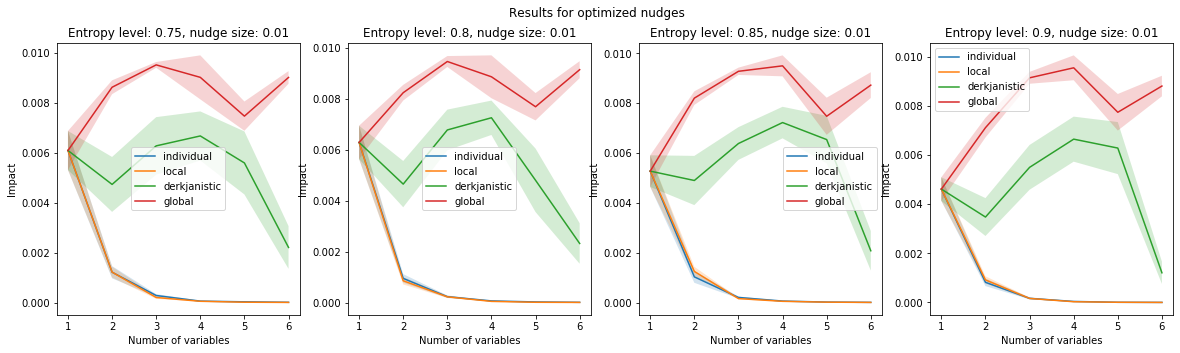

In [34]:
plot_results(n_vars, levels, create_dicts(combine_results(optim_results), dists, len(levels), len(n_vars)), "Results for optimized nudges")

In [ ]:
optim_results1000 = optim_results

# Debugging and tests

In [ ]:
%%timeit
x = x6
#individual_nudge(x)
local_nudge(x)
#synergistic_nudge(x)
#global_nudge(x)